In [49]:
ab = str('ab')
ab is 'ab'

True

In [9]:
%%writefile ../../src/models/model_utils.py
# %load ../../src/models/model_utils.py
# %%writefile ../../src/models/model_utils.py
"""
Author: Jim Clauwaert
Created in the scope of my PhD
"""


import pandas as pd
import numpy as np
import sklearn as sk
import math
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import PolynomialFeatures



def GetParameterSet(parLabel, parRange):
    
    """Retrieve a set of parameter values used for training of a model in sklearn. 
    
    Parameters
    -----------
    parLabel : 1-dimensional numpy array (str)
        numpy array holding a set of parameter labels. Valid labels include:
        [alpha, gamma, C, coef0, epsilon, max_depth, min_samples, max_features]
        
    parRange : 1-dimensional numpy array (int)
        numpy array with the amount of parameters returned for every parameter label. 
        parLabel and parRange must be of the same dimension.
        
    
    Returns
    --------
    parSet : Dictionary 
        Dictionary containing a set of parameters for every label
    """
    if parLabel[0] in ['max_depth','min_samples_split', 'max_features']:
        parameters = [np.zeros(parRange[u],dtype=np.int) for u in range(len(parRange))]
    else: 
        parameters = [np.zeros(parRange[u]) for u in range(len(parRange))]
  
    for i in range(len(parLabel)):
        if parLabel[i] == "alpha":
            parameters[i][:] = [math.pow(10,(u - np.around(parRange[i]/2))) for u in range(parRange[i])]
        elif parLabel[i] == "gamma":
            parameters[i][:] = [math.pow(10,(u - np.around(parRange[i]/2))) for u in range(parRange[i])]
        elif parLabel[i] == "C":
            parameters[i][:] = [math.pow(10,(u - np.around(parRange[i]/2))) for u in range(parRange[i])]
        elif parLabel[i] == "coef0":
            parameters[i][:] = [math.pow(10,(u - np.around(parRange[i]/2))) for u in range(parRange[i])]
        elif parLabel[i] == "epsilon":
            parameters[i][:] = [0+2/parRange[i]*u for u in range(parRange[i])]
        elif parLabel[i] == "max_depth":
            parameters[i][:] = [int(u+1) for u in range(parRange[i])]
        elif parLabel[i] == 'min_samples_split':
            parameters[i][:] = [int(u+2) for u in range(parRange[i])]
        elif parLabel[i] == 'max_features':
            parameters[i][:] = [int(u+2) for u in range(parRange[i])]
        else:
            return print("Not a valid parameter")
    
    parSet = {parLabel[u]:parameters[u] for u in range(len(parLabel))}
    
    return parSet

def EvaluateParameterSet(X_train, X_test, y_train, y_test, parModel, parSet):

    """Evaluate the scores of a set of parameters for a given model. 
    
    Parameters
    -----------
    X_train: 
        Training dataset features
        
    X_test: 
        Test dataset features
        
    y_train
        Training dataset labels
        
    y_test
        Test dataset labels
        
    parModel: Dictionary
        
    parSet : Dictionary
        Dictionary holding the parameter label and values over which the model has to be 
        evaluated. This can be created through the function GetParameterSet.
        Accepted keys are:
        [alpha, gamma, C, coef0, epsilon, max_depth, min_samples, max_features]
        
    
    Returns
    --------
    scores: 1-dimensional numpy array: int
        Fitted scores of the model with each of the parametersSets
    optimalPar: int
        Optimal parameter value for a given parameter label

    """
    
    scores = []

    for i in range(len(parSet[parLabel])):
        parSetIt = {parLabel:parSet[parLabel][i]}
        model = SelectModel(**parModel,**parEvalIt)
        model.fit(X_train,y_train)
        scores = np.append(model.score(X_test,y_test))
    
    optimalPar = parSet[parLabel][np.argmax(scores)]
    
    return scores, optimalPar

def EvaluateScore(X_train, X_test, y_train, y_test, parModel):
    
    """Evaluates the score of a model given for a given test and training data
    
    Parameters
    -----------
    X_train, X_test: DataFrame
        Test and training data of the features
    y_train, y_test: 1-dimensional numpy array
        Test and training data of the labels
    parModel: dictionary
        Parameters indicating the model and some of its features
        
    Returns
    --------
    score: int
        Score of the test data on the model
    y_pred: 1-dimensional array
        An array giving the predicted labels for a given test set
    
    """    

    model = SelectModel(**parModel)
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
 
    return score, y_pred

def LearningCurveInSample(dfDataset, featureBox, y ,parModel, k=5, pw=False, step=1):
    
    """Calculates the learning curve of a dataset for a given model
    
    Parameters
    -----------
    dfDataset: Dataframe
        Dataframe holding sequences,
        
    featureBox: Dataframe 
        Test dataset features
        
    y: 1-dimensional numpy array

        
    parModel: Dictionary
        
    k: int
    
    pw: Boolean
    
    step: int
        
    
    Returns
    --------
    scores: 1-dimensional numpy array: int
        Fitted scores of the model with each of the parametersSets
    optimalPar: int
        Optimal parameter value for a given parameter label

    """    
    X = featureBox.values
    
    if pw is True:

        temp = np.unique(dfDataset[['ID_1', 'ID_2']].values)
        dfId = pd.Series(temp[:-(len(temp)%k)])
    else: 
        dfId = dfDataset['ID'][:-(len(dfDataset)%k)]

    lenId = len(dfId)
    Id = dfId.values
    indexId = np.array(range(lenId))

    scores = np.array([])
    it=0

    for i in range(k):
        boolTest = np.logical_and(indexId>=i*lenId/k,indexId<(i+1)*lenId/k)
        test = Id[boolTest]
        train = Id[np.invert(boolTest)]
        if pw is True:
            indexTest = (dfDataset['ID_1'].isin(test) | dfDataset['ID_2'].isin(test)).values
        else:        
            indexTest = dfDataset['ID'].isin(test).values

        dfDatasetTrain = dfDataset[np.invert(indexTest)]
        X_train, y_train = featureBox[np.invert(indexTest)], y[np.invert(indexTest)]
        X_test, y_test = featureBox[indexTest], y[indexTest]
        for j in range((len(train)-5)//step):
            print("\rProgress {:2.1%}".format(it/k+(j/len(train)/k*step)), end='')
            trainInner = train[:(j*step)+5]
            if pw is True:
                indexTrainInner = (dfDatasetTrain['ID_1'].isin(trainInner) & dfDatasetTrain['ID_2'].isin(trainInner)).values
            else:
                indexTrainInner = (dfDatasetTrain['ID'].isin(trainInner)).values
            X_trainInner, y_trainInner = X_train[indexTrainInner], y_train[indexTrainInner]
            score, y_pred = EvaluateScore(X_trainInner, X_test, y_trainInner, y_test, {**parModel})
            scores = np.append(scores,score)

        it+=1

    scores = scores.reshape((k,-1))
    
    return scores

def LearningCurveInSampleEnriched(dfDataset, featureBox, enrichBox, y, y_enrich ,parModel, k=5, pw=True, step=1):

    """Calculates the learning curve of an enriched dataset for a given model
    
    Parameters
    -----------
    dfDataset: Dataframe
        Dataframe holding sequences,
        
    featureBox: Dataframe 
        Test dataset features
        
    y: 1-dimensional numpy array

        
    parModel: Dictionary
        
    k: int
    
    pw: Boolean
    
    step: int
        
    
    Returns
    --------
    scores: 1-dimensional numpy array: int
        Fitted scores of the model with each of the parametersSets
    optimalPar: int
        Optimal parameter value for a given parameter label

    """

    if pw is True:

        temp = np.unique(dfDataset[['ID_1', 'ID_2']].values)
        dfId = pd.Series(temp[:-(len(temp)%k)])
    else: 
        dfId = dfDataset['ID'][:-(len(dfDataset)%k)]

    lenId = len(dfId)
    Id = dfId.values
    indexId = np.array(range(lenId))

    scores = np.array([])
    it=0

    for i in range(k):
        boolTest = np.logical_and(indexId>=i*lenId/k,indexId<(i+1)*lenId/k)
        test = Id[boolTest]
        train = Id[np.invert(boolTest)]
        if pw is True:
            indexTest = (dfDataset['ID_1'].isin(test) | dfDataset['ID_2'].isin(test)).values
        else:        
            indexTest = dfDataset['ID'].isin(test).values

        dfDatasetTrain = dfDataset[np.invert(indexTest)]
        X_train = featureBox[np.invert(indexTest)]
        y_train = y[np.invert(indexTest)]
        X_test, y_test = featureBox[indexTest], y[indexTest]
        for j in range((len(train))//step):
            print("\rProgress {:2.1%}".format(it/k+(j/len(train)/k*step)), end='')
            trainInner = train[:(j*step)]
            if pw is True:
                indexTrainInner = (dfDatasetTrain['ID_1'].isin(trainInner) & dfDatasetTrain['ID_2'].isin(trainInner)).values
            else:
                indexTrainInner = (dfDatasetTrain['ID'].isin(trainInner)).values
            X_trainInner = np.vstack((enrichBox,X_train[indexTrainInner]))
            y_trainInner =  np.append(y_enrich, y_train[indexTrainInner])
            score, y_pred = EvaluateScore(X_trainInner, X_test, y_trainInner, y_test, {**parModel})
            scores = np.append(scores,score)

        it+=1

    scores = scores.reshape((k,-1))
    
    return scores


def LearningCurveOutOfSample(dfDataset, featureBox, y , dataList, parModel, pw=False, step=1):

    """Calculates the learning curve of a dataset for a given model
    
    Parameters
    -----------
    dfDataset: Dataframe
        Dataframe holding sequences,
        
    featureBox: Dataframe 
        Test dataset features
        
    y: 1-dimensional numpy array

        
    parModel: Dictionary
        
    k: int
    
    pw: Boolean
    
    step: int
        
    
    Returns
    --------
    scores: 1-dimensional numpy array: int
        Fitted scores of the model with each of the parametersSets
    optimalPar: int
        Optimal parameter value for a given parameter label

    """

    if pw is True:
        temp = np.unique(dfDataset[['ID_1', 'ID_2']].values)
        dfId = pd.Series(temp)
    else: 
        dfId = dfDataset['ID']

    lenId = len(dfId)
    Id = dfId.values
    indexId = np.array(range(lenId))

    scores = np.zeros(shape=(len(dataList),(lenId-5)//step))

    for i in range((lenId-5)//step):
        print("\rProgress {:2.1%}".format(i/lenId*step), end='')
        train = Id[:((i*step)+5)]
        if pw is True:
            indexTrain = (dfDataset['ID_1'].isin(train) & dfDataset['ID_2'].isin(train)).values
        else:        
            indexTrain = dfDataset['ID'].isin(train).values
        X_train, y_train = featureBox[indexTrain], y[indexTrain]
        for j in range(len(dataList)):
            score, y_pred = EvaluateScore(X_train, dataList[j][1].values, y_train, dataList[j][2], {**parModel})
            if pw is True:
                scores[j,i] = score
            else:
                scores[j,i] = abs(stats.spearmanr(dataList[j][0]['mean_score'],y_pred)[0])

    return scores

def LearningCurveOutOfSampleEnriched(dfDataset, featureBox, enrichBox, y, y_enrich, dataOutList, parModel, pw=True, step=1):
    
    if pw is True:
        temp = np.unique(dfDataset[['ID_1', 'ID_2']].values)
        dfId = pd.Series(temp)
    else: 
        dfId = dfDataset['ID']

    lenId = len(dfId)
    Id = dfId.values
    indexId = np.array(range(lenId))

    scores = np.zeros(shape=(len(dataOutList),(lenId)//step))

    for i in range((lenId)//step):
        print("\rProgress {:2.1%}".format(i/lenId*step), end='')
        train = Id[:(i*step)]
        if pw is True:
            indexTrain = (dfDataset['ID_1'].isin(train) & dfDataset['ID_2'].isin(train)).values
        else:        
            indexTrain = dfDataset['ID'].isin(train).values
        X_train = np.vstack((enrichBox ,featureBox[indexTrain]))
        y_train = np.append(y_enrich, y[indexTrain])
        for j in range(len(dataOutList)):
            score, y_pred = EvaluateScore(X_train, dataOutList[j][1].values, y_train, dataOutList[j][2], {**parModel})
            if pw is True:
                scores[j,i] = score
            else:
                scores[j,i] = abs(stats.spearmanr(dataOutList[j][0]['mean_score'],y_pred)[0])

    return scores

def SelectModel(modelType, poly=None, kernel=None, alpha=0.1, gamma=0.1, epsilon=0.1, coef0=1,  
                     fitInt=True, normalize=True, max_depth=None, max_features=None, min_samples_split = 2, 
                     n_estimators = 50, C=1, n_jobs=12):
    
    """ Initializes the correct model for a given set of parameters. 
    
    Parameters
    -----------
    modelType: str
        Type of model. Possible values are:
        ['ridge',  'SVC', 'SVR', OLS', 'lasso', 'huber', 'treeReg', 'treeClass', 'forestReg', 'forestClass']
    
    other parameters include (further information can be found on sklearn):
    poly: int
    kernel: str
    alpha: int
    gamma: int
    epsilon: int
    coef0: int
    fit_intercept= Bool
    normalize = Bool
    max_depth = int
    max_features = int
    min_samples_split = int
    n_estimators = int
    C = int
    n_jobs= int
    
    Returns
    -------
    model: Class 
        sklearn-type model
    
    
    """
    
    if kernel:
        if modelType == "ridge":
            model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel, coef0=coef0)
        if modelType == "SVC":
            model = SVC(C=C, kernel=kernel, gamma=gamma, coef0=coef0, degree=poly)
        if modelType == "SVR":
            model = SVR(C=C, kernel=kernel, gamma=gamma, coef0=coef0, epsilon=epsilon, degree=poly)
                    
    elif poly:
        if modelType == "OLS":
            model = make_pipeline(PolynomialFeatures(poly), LinearRegression(fit_intercept=fit_intercept, normalize=normalize))
        if modelType == "ridge":
            model = make_pipeline(PolynomialFeatures(poly), Ridge(alpha= alpha, normalize=normalize))
        if modelType == "lasso":
            model = make_pipeline(PolynomialFeatures(poly), Lasso(alpha= alpha, normalize=normalize))
        if modelType == "huber":
            model = make_pipeline(PolynomialFeatures(poly), HuberRegressor(fit_intercept=fitInt, epsilon=epsilon, alpha=alpha))

    else: 
        if modelType == "OLS":
            model = LinearRegression(fit_intercept=fitInt, normalize=normalize)
        if modelType == "ridge":
            model = Ridge(alpha= alpha, normalize=normalize)
        if modelType == "lasso":
            model = Lasso(alpha= alpha, normalize=normalize)
        if modelType == "huber":
            model = HuberRegressor(fit_intercept=fitInt, alpha=alpha, epsilon=epsilon)
        if modelType == "treeReg":
            model = DecisionTreeRegressor(max_depth= max_depth, max_features=max_features, min_samples_split = min_samples_split)
        if modelType == "treeClass":
            model = DecisionTreeClassifier(max_depth = max_depth, max_features=max_features, min_samples_split = min_samples_split)
        if modelType == "forestReg":
            model = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features= max_features, min_samples_split = min_samples_split, n_jobs=n_jobs)
        if modelType == "forestClass":
            model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features= max_features, min_samples_split = min_samples_split, n_jobs=n_jobs)
    
    return model


def SetupModel(modelInit, parOptional={}):
    #model selection and hyperparameters
    modelType = modelInit[0]
    kernel = modelInit[1]
    poly= modelInit[2]

    parModel = {"modelType":modelType, "poly":poly, "kernel":kernel, **parOptional }
    
    return parModel



Overwriting ../../src/models/model_utils.py


In [43]:
GetParameterSet(['alpha', 'gamma'],[10, 10])

{'alpha': array([  1.00000000e-05,   1.00000000e-04,   1.00000000e-03,
          1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
          1.00000000e+01,   1.00000000e+02,   1.00000000e+03,
          1.00000000e+04]),
 'gamma': array([  1.00000000e-05,   1.00000000e-04,   1.00000000e-03,
          1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
          1.00000000e+01,   1.00000000e+02,   1.00000000e+03,
          1.00000000e+04])}

In [5]:
import sys
sys.path.append("../../src/")
import features.feature_utils as fu
import models.model_utils as mu
import plots.plot_utils as pu
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import GridSearchCV
%matplotlib inline


In [31]:
model = ['forestClass',None,None]
modelOpt = {'n_estimators':10}

pw = True
step = 2
seqRegions = [[0,12],[-6,11]]

data = '../../data/interim/pw_hammer_prom_lib.csv'
dataEnrich = ['../../data/interim/pw_mutalik_prom_lib.csv']
dataOut = ['../../data/interim/pw_anderson_prom_lib.csv','../../data/interim/pw_brewster_prom_lib.csv'
          ,'../../data/interim/pw_inbio_prom_lib.csv']

dataOutLabels = ['anderson','brewster','inbio']


In [27]:
def LearningCurveOutOfSampleEnriched(dfDataset, featureBox, enrichBox, y, y_enrich, dataOutList, parModel, pw=False, step=1):
    
    if pw is True:
        temp = np.unique(dfDataset[['ID_1', 'ID_2']].values)
        dfId = pd.Series(temp)
    else: 
        dfId = dfDataset['ID']

    lenId = len(dfId)
    Id = dfId.values
    indexId = np.array(range(lenId))

    scores = np.zeros(shape=(len(dataOut),(lenId-5)//step))

    for i in range((lenId)//step):
        print("\rProgress {:2.1%}".format(i/len(Id)), end='')
        train = Id[:(i*step)]
        if pw is True:
            indexTrain = (dfDataset['ID_1'].isin(train) & dfDataset['ID_2'].isin(train)).values
        else:        
            indexTrain = dfDataset['ID'].isin(train).values
        X_train = np.vstack((enrichBoxFull ,featureBox[indexTrain]))
        y_train = np.append(y_enrich, y[indexTrain])
        for j in range(len(dataOut)):
            score, y_pred = EvaluateScore(X_train, dataOutList[j][1].values, y_train, dataOutList[j][2], {**parModel})
            if pw is True:
                scores[j,i] = score
            else:
                scores[j,i] = abs(stats.spearmanr(dataOutList[j][0]['mean_score'],y_pred)[0])

    return scores

In [32]:
parModel = SetupModel(model,modelOpt)


dfDataset , featureBox = fu.CreateFeaturesFromData(data, seqRegions, pw, shuffle=True)
data

enrichBoxList = []
y_enrich = []
for e in dataEnrich:
    dfEnrich, enrichBox = fu.CreateFeaturesFromData(e, seqRegions, pw)
    y = dfEnrich['rank']
    enrichBoxList.append(enrichBox)
    y_enrich.append(y)
    #dataEnrichList.append((dfEnrich, enrichBox, y))

enrichBox = np.vstack((enrichBoxList[:]))

dataOutList = []
for d in dataOut:
    dfOut, outBox = fu.CreateFeaturesFromData(d, seqRegions, pw)
    y = dfOut['rank']
    dataOutList.append((dfOut, outBox, y))

X = featureBox.values
y = dfDataset['rank']

scores = LearningCurveOutOfSampleEnriched(dfDataset, featureBox, enrichBox, y, y_enrich, dataOutList, parModel, pw, step)

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.set_title("Learning curve out of sample score")
colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
for j in range(len(dataOut)):
    ax.plot(range((lenId)//step),scores[j,:], colors[j], label=dataOutLabels[j])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Step")
ax.set_ylabel("Score")



Progress 41.7%rogress 2.8%

IndexError: index 15 is out of bounds for axis 1 with size 15

In [21]:
model = ['forestClass',None,None]
modelOpt = {'n_estimators':10}
k= 5
pw = True
step = 1
seqRegions = [[-7,12],[-6,11]]
data = '../../data/interim/pw_hammer_prom_lib.csv'
dataEnrich= '../../data/interim/pw_mutalik_prom_lib.csv'

dfDataset , featureBox = fu.CreateFeaturesFromData(data, seqRegions, pw, shuffle=True)
dfEnrich, enrichBox = fu.CreateFeaturesFromData(dataEnrich, seqRegions, pw, shuffle=True)

X_enrich = enrichBox.values
y_enrich = dfEnrich['rank']

X = featureBox.values
y = dfDataset['rank']

parModel = mu.SetupModel(model, modelOpt)



In [20]:
scores

array([], shape=(3, 0), dtype=float64)

Progress 99.3%rogress 0.7%

[]

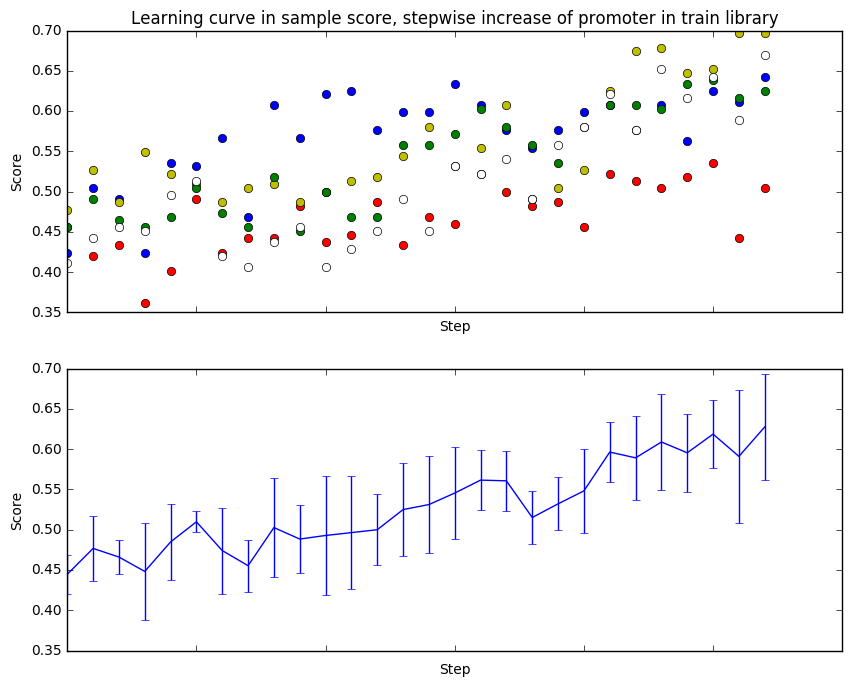

In [22]:
if pw is True:

    temp = np.unique(dfDataset[['ID_1', 'ID_2']].values)
    dfId = pd.Series(temp[:-(len(temp)%k)])
else: 
    dfId = dfDataset['ID'][:-(len(dfDataset)%k)]

lenId = len(dfId)
Id = dfId.values
indexId = np.array(range(lenId))

scores = np.array([])
it=0

for i in range(k):
    boolTest = np.logical_and(indexId>=i*lenId/k,indexId<(i+1)*lenId/k)
    test = Id[boolTest]
    train = Id[np.invert(boolTest)]
    if pw is True:
        indexTest = (dfDataset['ID_1'].isin(test) | dfDataset['ID_2'].isin(test)).values
    else:        
        indexTest = dfDataset['ID'].isin(test).values

    dfDatasetTrain = dfDataset[np.invert(indexTest)]
    X_train = featureBox[np.invert(indexTest)]
    y_train = y[np.invert(indexTest)]
    X_test, y_test = featureBox[indexTest], y[indexTest]
    for j in range((len(train))//step):
        print("\rProgress {:2.1%}".format(it/k+(j/len(train)/k)), end='')
        trainInner = train[:(j*step)]
        if pw is True:
            indexTrainInner = (dfDatasetTrain['ID_1'].isin(trainInner) & dfDatasetTrain['ID_2'].isin(trainInner)).values
        else:
            indexTrainInner = (dfDatasetTrain['ID'].isin(trainInner)).values
        X_trainInner = np.vstack((enrichBox,X_train[indexTrainInner]))
        y_trainInner =  np.append(y_enrich, y_train[indexTrainInner])
        score, y_pred = mu.EvaluateScore(X_trainInner, X_test, y_trainInner, y_test, {**parModel})
        scores = np.append(scores,score)

    it+=1

scores = scores.reshape((k,-1))

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,8),sharex=True)

ax1.set_title("Learning curve in sample score of enriched dataset")
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    ax1.plot(range(len(scores[i,:])),scores[i,:], colors[i])
ax1.set_xlabel("Step")
ax1.set_ylabel("Score")
meanScores=np.mean(scores,axis=0)
stdScores=np.std(scores,axis=0)
ax2.errorbar(range(len(meanScores)), meanScores[:], stdScores[:])
ax2.set_xlabel("Step")
ax2.set_ylabel("Score")


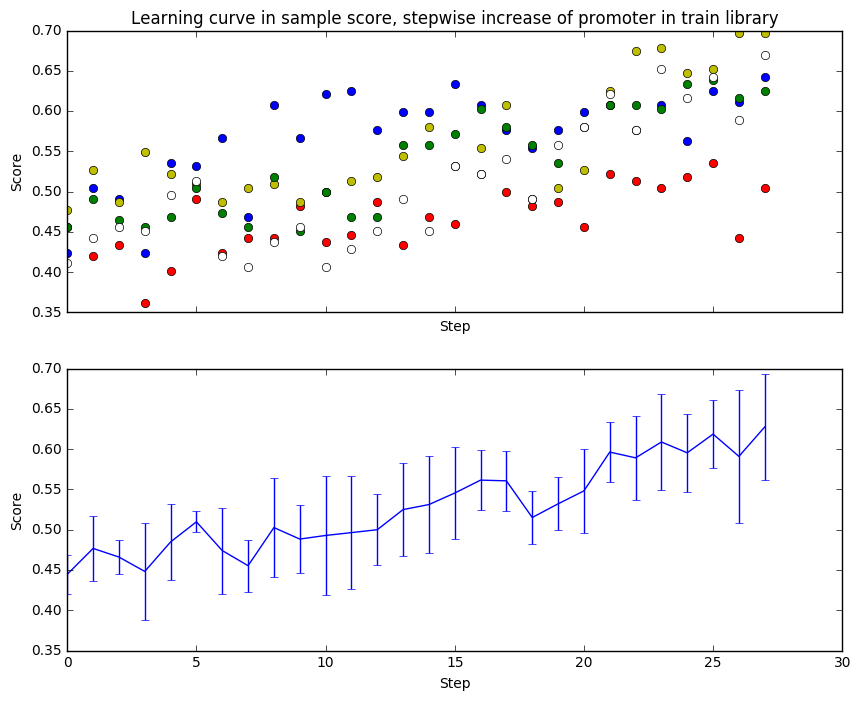

In [24]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,8),sharex=True)

ax1.set_title("Learning curve in sample score, stepwise increase of promoter in train library")
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    ax1.plot(range(len(scores[i,:])),scores[i,:], colors[i])
ax1.set_xlabel("Step")
ax1.set_ylabel("Score")
meanScores=np.mean(scores,axis=0)
stdScores=np.std(scores,axis=0)
ax2.errorbar(range(len(meanScores)), meanScores[:], stdScores[:])
ax2.set_xlabel("Step")
ax2.set_ylabel("Score")


In [50]:

dfDataset = pd.read_csv('../../data/interim/pw_mutalik_prom_lib.csv')
dfDatasetAligned = fu.AlignSequences(dfDataset, pw=True)

dfDatasetShuffled , featureBox = fu.PositionalFeaturesPW(dfDatasetAligned, [[-7,12],[-6,11]], shuffle=True)

X = featureBox.values
y = dfDatasetShuffled['rank']

"""parSet = GetParameterSet(parLabel, parRange)


model = SelectModel(**parModel)
GS = GridSearchCV(model, parSet, cv=k, n_jobs=n_jobs)
GS.fit(X,y)"""

'parSet = GetParameterSet(parLabel, parRange)\n\n\nmodel = SelectModel(**parModel)\nGS = GridSearchCV(model, parSet, cv=k, n_jobs=n_jobs)\nGS.fit(X,y)'

In [10]:
GS.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma=1.0, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
np.unique(dfDatasetShuffled[['ID_1']].values).size

253

In [38]:
scores

array([ 0.33934354,  0.35658643,  0.5590372 ,  0.55002188,  0.56630197,
        0.54013129,  0.52770241,  0.49986871,  0.47474836,  0.4604814 ,
        0.44822757,  0.47343545,  0.4697593 ,  0.57995624,  0.58196937,
        0.54249453,  0.55002188,  0.56647702,  0.57461707,  0.57741794,
        0.58091904,  0.57890591,  0.58284464,  0.57776805,  0.60157549,
        0.59929978,  0.60525164,  0.59991247,  0.60078775,  0.61916849,
        0.62555799,  0.62932166,  0.64253829,  0.63045952])

In [29]:
len(train)*5

1020